# e-Stat からのデータ取得、データ整形と簡易的な分析


## 概要

このノートブックでは、e-Stat から API を用いてデータを取得し、データを json ファイルから Dataframe 型で分析に使える形に整形します。
また、作ったデータを用いて、簡単な分析を行います。

今回は、 https://www.e-stat.go.jp/en/dbview?sid=0004012600
こちらの業種別売上データを取得します。



- [政府統計の総合窓口](https://www.e-stat.go.jp/) にはさまざまなデータが掲載されています。

- データは、 CSV形式でダウンロードでき、 API接続でも取得できます。

- 時系列データを APIで取得し、 Google Colaboratory で分析を行ってみます。


# 1. 準備

## 1.1 アプリケーションID (appId) の取得と入力


- [政府統計の総合窓口(e-Stat)−API機能 | 政府統計の総合窓口(e-Stat)−API機能](https://www.e-stat.go.jp/api/)

上のページから appId を取得して下さい。2番の `APIにより必要なjsonデータを取得` の項で必要になります。


In [1]:
# e-Stat に登録して取得したアプリケーションID (appId) を、 APP_ID へ入力して下さい。
APP_ID = "XXXXXX"

## 1.2 インストール

1. Google Colaboratory のメニューから `▷ すべてのセルを実行` をクリックし、全て実行します。

2. `numpy` のダウングレードの箇所で、エラーで停止します。 `Restart Session` というボタンが表示されるので、セッションの再起動を行います。

3. 再び、 Google Colaboratory のメニューから `▷ すべてのセルを実行` をクリックし、全て実行します。

### `numpy` のダウングレード（要：セッションの再起動）

今回は、APIを使うための `requests` ,
数値解析やデータ整形に `numpy` , `pandas` ,
グラフの描写に `matplotlib` , 時系列分析のための `pmdarima` などを用います。

- 必要なパッケージのインストール
  - 単に `pmdarima` をインストールすると、 Google Colaboratory の `numpy` のバージョンとの整合性でエラーが生じます。

- そこで、 Google Colaboratory の `numpy` を 1.26.4 へダウングレードします。

  - [【解決】ValueError: numpy.dtype size changedエラーを徹底解説！PandasとNumPyのバージョン互換性問題](https://openillumi.com/numpy-dtype-size-changed-fix/)


- `numpy` のダウングレードには、 <B><font color = red>セッションの再起動が必要</font></B> となります。

  `pip install numpy==1.26.4` を実行後、メッセージが出て促されますので、 <B><font color = red>セッションの再起動</font></B> を行い、画面上のメニューから <B><font color = red>▷ すべてのセルを実行</font></B>  を行います。


In [2]:
pip install numpy==1.26.4

### 時系列分析のための `pmdarima` のインストール

- 時系列分析を行うため、 `pmdarima` をインストールします。

  - 繰り返しになりますが、現在の Google Colaboratory のデフォルトでは `numpy` が 2.0 以上のため、エラーになります。

  - `numpy` を 1.26.4 にダウングレードして、セッションを再起動すると、 `pmdarima` のインストールが成功します。
  

In [3]:
pip install pmdarima

### 日本語フォントのインストール

- グラフで日本語フォントを表示させるため、  `japanize_matplotlib` をインストールします。


In [4]:
pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=03bf1c6e3a999165e6cf81401309f5629de35fbfc66692bff0e45bc3c3f9b292
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib


## 1.3 ライブラリのインポート

- 各種ライブラリを `import` します。

In [5]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import pmdarima as pm
import japanize_matplotlib  # matplotlib の日本語文字化け対策
import sys
import re
import matplotlib.dates as mdates


# 2. e-Stat の API により今回必要な json データを取得


`requests` を使って、 API からデータを取得します （ `APP_ID` が入力されている必要があります）。

`BASE` に API の URL を設定し、 `lang` を `E` とする事で、英語名で取得します。

これを実行する事で、 `res` に生データが入ります。

`res` に入った生データを json ファイルに変換します。

In [6]:
STATS_ID = "0003179100"
BASE = "https://api.e-stat.go.jp/rest/3.0/app/json/getStatsData"
params = {
    "appId": APP_ID,
    "statsDataId": STATS_ID,
    "lang": "E",
    "metaGetFlg": "Y",
    "cntGetFlg": "N",
    "startPosition": 1,
    "limit": 100000
}

res = requests.get(BASE, params=params, timeout=60)
js = res.json()
vals = js["GET_STATS_DATA"]["STATISTICAL_DATA"]["DATA_INF"]["VALUE"]
df = pd.json_normalize(vals)
print(df.head)


<bound method NDFrame.head of      @tab @cat01  @area       @time      @unit         $
0     001  00000  00000  2013000000  1 mil.yen  31036119
1     001  00000  00000  2014000000  1 mil.yen  31601470
2     001  00000  00000  2015000000  1 mil.yen  32544364
3     001  00000  00000  2016000000  1 mil.yen  32829582
4     001  00000  00000  2017000000  1 mil.yen  33432033
...   ...    ...    ...         ...        ...       ...
8971  001  20000  00000  2023000808  1 mil.yen   1050430
8972  001  20000  00000  2023000909  1 mil.yen   1169145
8973  001  20000  00000  2023901010  1 mil.yen   1057912
8974  001  20000  00000  2023901111  1 mil.yen   1069434
8975  001  20000  00000  2023901212  1 mil.yen   1120398

[8976 rows x 6 columns]>


## データの編集

- jsonファイルをデータフレームにしたので、class_informationテーブルから、各列の情報に対応する辞書を作る

- この辞書を使って、数字で保存されている情報を元のラベルに振り直す


In [7]:
def to_list(x):
    if isinstance(x, list):
        return x
    else:
        return [x]

classes = js["GET_STATS_DATA"]["STATISTICAL_DATA"]["CLASS_INF"]["CLASS_OBJ"]
classes = to_list(classes)
#print(classes)
code_to_name = {}
print(df)
for c in classes:
    cid = c["@id"]
    items = to_list(c.get("CLASS"))
    code_to_name[cid] = {it["@code"]: it["@name"] for it in items}

df["industry"] = df["@cat01"].map(code_to_name["cat01"])
df["area"] = df["@area"].map(code_to_name["area"])
df["time_name"] = df["@time"].map(code_to_name["time"])
df["value"] = pd.to_numeric(df["$"])
print(df[:10])

     @tab @cat01  @area       @time      @unit         $
0     001  00000  00000  2013000000  1 mil.yen  31036119
1     001  00000  00000  2014000000  1 mil.yen  31601470
2     001  00000  00000  2015000000  1 mil.yen  32544364
3     001  00000  00000  2016000000  1 mil.yen  32829582
4     001  00000  00000  2017000000  1 mil.yen  33432033
...   ...    ...    ...         ...        ...       ...
8971  001  20000  00000  2023000808  1 mil.yen   1050430
8972  001  20000  00000  2023000909  1 mil.yen   1169145
8973  001  20000  00000  2023901010  1 mil.yen   1057912
8974  001  20000  00000  2023901111  1 mil.yen   1069434
8975  001  20000  00000  2023901212  1 mil.yen   1120398

[8976 rows x 6 columns]
  @tab @cat01  @area       @time      @unit         $ industry   area  \
0  001  00000  00000  2013000000  1 mil.yen  31036119    Total  Japan   
1  001  00000  00000  2014000000  1 mil.yen  31601470    Total  Japan   
2  001  00000  00000  2015000000  1 mil.yen  32544364    Total  Japan   

データの中身を確認します。


In [8]:
df["time_name"].unique()

array(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023  p', 'Jan.-Mar. 2013', 'Apr.-Jun. 2013',
       'Jul.-Sep. 2013', 'Oct.-Dec. 2013', 'Jan.-Mar. 2014',
       'Apr.-Jun. 2014', 'Jul.-Sep. 2014', 'Oct.-Dec. 2014',
       'Jan.-Mar. 2015', 'Apr.-Jun. 2015', 'Jul.-Sep. 2015',
       'Oct.-Dec. 2015', 'Jan.-Mar. 2016', 'Apr.-Jun. 2016',
       'Jul.-Sep. 2016', 'Oct.-Dec. 2016', 'Jan.-Mar. 2017',
       'Apr.-Jun. 2017', 'Jul.-Sep. 2017', 'Oct.-Dec. 2017',
       'Jan.-Mar. 2018', 'Apr.-Jun. 2018', 'Jul.-Sep. 2018',
       'Oct.-Dec. 2018', 'Jan.-Mar. 2019', 'Apr.-Jun. 2019',
       'Jul.-Sep. 2019', 'Oct.-Dec. 2019', 'Jan.-Mar. 2020',
       'Apr.-Jun. 2020', 'Jul.-Sep. 2020', 'Oct.-Dec. 2020',
       'Jan.-Mar. 2021', 'Apr.-Jun. 2021', 'Jul.-Sep. 2021',
       'Oct.-Dec. 2021', 'Jan.-Mar. 2022', 'Apr.-Jun. 2022',
       'Jul.-Sep. 2022', 'Oct.-Dec. 2022', 'Jan.-Mar. 2023',
       'Apr.-Jun. 2023', 'Jul.-Sep. 2023', 'Oct.-Dec. 2023  p',
  

これを見ると、今回取ってきたデータセットでは、1年ごとのデータ、四半期ごとのデータも入っています。今回は、月別のデータを使って分析したいので、必要なデータのみ分離します。

In [9]:
target_list = []
df["time_name"] = df["time_name"].replace("  p", "")
for word in df["time_name"].unique():
  if "-" not in word and not word.isnumeric():
    target_list.append(word)
#print(target_list)
df_monthly = df[df["time_name"].isin(target_list)]
#print(df_monthly)

month_map = {
    "Jan.": "01", "Feb.": "02", "Mar.": "03", "Apr.": "04",
    "May ": "05", "Jun.": "06", "Jul.": "07", "Aug.": "08",
    "Sep.": "09", "Oct.": "10", "Nov.": "11", "Dec.": "12"
}

def convert_month(x):
  for m,num in month_map.items():
    if m in x:
      year = re.sub(r"[A-Za-z\.\-\s]", "", x)
      return year+num

df_monthly["date"] = df_monthly["time_name"].apply(convert_month)
df_monthly["date"] = pd.to_datetime(df_monthly["date"], format="%Y%m")
df_monthly = df_monthly.dropna(subset=["date"])
df_monthly.head()

/tmp/ipython-input-2265847218.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly["date"] = df_monthly["time_name"].apply(convert_month)
/tmp/ipython-input-2265847218.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly["date"] = pd.to_datetime(df_monthly["date"], format="%Y%m")


,@tab,@cat01,@area,@time,@unit,$,industry,area,time_name,value,date
55,001,00000,00000,2013000101,1 mil.yen,28845922,Total,Japan,Jan. 2013,28845922,2013-01-01
56,001,00000,00000,2013000202,1 mil.yen,28892736,Total,Japan,Feb. 2013,28892736,2013-02-01
57,001,00000,00000,2013000303,1 mil.yen,35433719,Total,Japan,Mar. 2013,35433719,2013-03-01
58,001,00000,00000,2013000404,1 mil.yen,30163888,Total,Japan,Apr. 2013,30163888,2013-04-01
59,001,00000,00000,2013000505,1 mil.yen,30198633,Total,Japan,May 2013,30198633,2013-05-01


これで `date` 列に `datetime` 型となった日にちを入れることができました。

データ分析ができる形になったので、実際に分析をしていきます。

In [10]:
df["industry"].unique()

array(['Total', 'Service industry', 'G Information and communications',
       '37Communications', '38Broadcasting', '39Information services',
       '40Internet based services',
       '41Video picture, sound information, character information production and distribution',
       'H Transport and postal activities', '42Railway transport',
       '43Road passenger transport', '44Road freight transport',
       '45Water transport', '47Warehousing',
       '48Services incidental to transport',
       '4*Air transport, Postal activities, including mail delivery',
       'K Real estate and goods rental and leasing',
       '68Real estate agencies', '69Real estate lessors and managers',
       '70Goods rental and leasing',
       'L Scientific research, professional and technical services  (*Excluding "scientific and development research institutes" (since January, 2013) and "pure holding companies" (since January, 2013))',
       '72Professional services, n.e.c. (*Excluding "pure holding c

# 3. 飲食店の売上

データの産業の種類を表す `industry` 列に入っている内容を確認します。

確認したところ、 `"76Eating and drinking places"` という値が存在します。

今回は、このデータを使って、飲食店の売上を時系列順にプロットしてみます。まずは、飲食店のデータだけを取り出します。

In [11]:
df_eating = df_monthly.dropna(subset=["date"])[df["industry"] == "76Eating and drinking places"].copy()
#print(df_eating.shape)
#print(df_eating["date"].dtype)

start = "2018-01-01"
end   = "2018-08-01"
df_range = df_eating[(df_eating["date"] >= start) & (df_eating["date"] <= end)]
df_range

/tmp/ipython-input-714293820.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_eating = df_monthly.dropna(subset=["date"])[df["industry"] == "76Eating and drinking places"].copy()


,@tab,@cat01,@area,@time,@unit,$,industry,area,time_name,value,date
4977,001,06020,00000,2018000101,1 mil.yen,2045513,76Eating and drinking places,Japan,Jan. 2018,2045513,2018-01-01
4978,001,06020,00000,2018000202,1 mil.yen,1886559,76Eating and drinking places,Japan,Feb. 2018,1886559,2018-02-01
4979,001,06020,00000,2018000303,1 mil.yen,2276109,76Eating and drinking places,Japan,Mar. 2018,2276109,2018-03-01
4980,001,06020,00000,2018000404,1 mil.yen,2153076,76Eating and drinking places,Japan,Apr. 2018,2153076,2018-04-01
4981,001,06020,00000,2018000505,1 mil.yen,2130518,76Eating and drinking places,Japan,May 2018,2130518,2018-05-01
4982,001,06020,00000,2018000606,1 mil.yen,2066814,76Eating and drinking places,Japan,Jun. 2018,2066814,2018-06-01
4983,001,06020,00000,2018000707,1 mil.yen,2148546,76Eating and drinking places,Japan,Jul. 2018,2148546,2018-07-01
4984,001,06020,00000,2018000808,1 mil.yen,2276854,76Eating and drinking places,Japan,Aug. 2018,2276854,2018-08-01


取り出せたので、飲食店の売上データ `df_eating` をプロットしてみます。


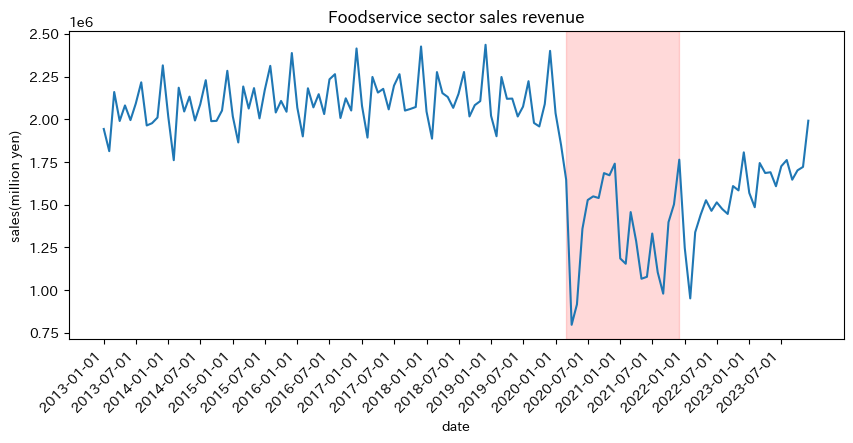

In [12]:
plt.figure(figsize=(10,4))
plt.plot(df_eating.date, df_eating.value, label="money")
plt.xlabel("date")
plt.ylabel("sales(million yen)")
plt.title("Foodservice sector sales revenue")
step = 6
xticks = df_eating["date"].iloc[::step]   # 5行おきに抜き出す

plt.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-01"),
            color="red", alpha=0.15, label="COVID period")

plt.xticks(xticks, rotation=45, ha="right")
plt.show()

今回の分析では、飲食業界に大きな影響があった、コロナウイルス流行期間の背景を赤くしてわかりやすくしています。

今回のデータでは2020年春頃にガクッと売り上げが落ちているのがわかります。
これはちょうど日本でCOVID-19が流行し始め、自発的なロックダウンが行われていた頃です。これは、当時の日本では前例のない出来事で、印象深かった方も多いのではないでしょうか。
このように、データを整えてグラフとして情報を出力することで、データから背景を推測するといったデータの活用を行うことができます。


ところで、コロナ前(2020年前)の飲食店の売上データでは、1年ごとに同じような動きを繰り返しているように見えます。
そこで、1年ごとの季節により売り上げの変化の傾向は、コロナ前、流行時、後で変化したのかを比較してみます。

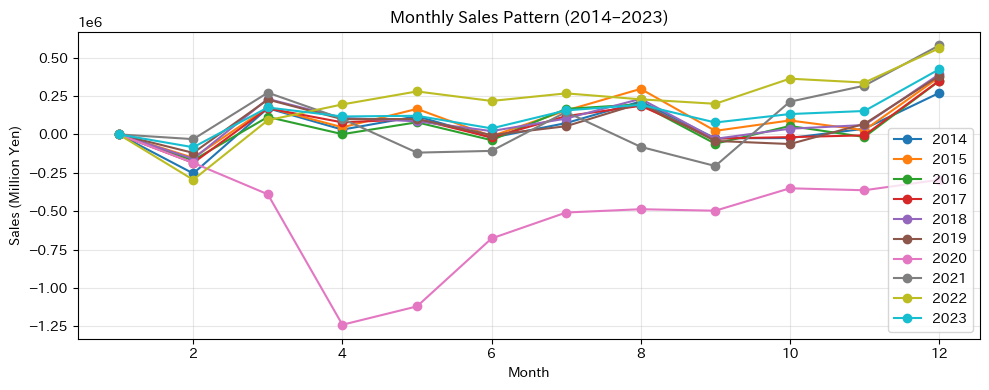

In [13]:
plt.figure(figsize=(10,4))
df_eating["year"]  = df_eating["date"].dt.year
df_eating["month"] = df_eating["date"].dt.month
for year in range(2014,2024):
    sub = df_eating[df_eating["year"] == year].copy()
    sub["value"] -= sub["value"].iloc[0]
    sub["dummy_date"] = sub["date"].dt.month
    sub = sub.groupby("dummy_date")["value"].mean().sort_index()
    plt.plot(sub.index, sub.values, marker="o", label=str(year))

plt.xlabel("Month"); plt.ylabel("Sales (Million Yen)")
plt.title("Monthly Sales Pattern (2014–2023)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

上のグラフでは、各年の1月の売り上げを0として、どれだけ売り上げが変化しているかをプロットしています。

その結果、流行が起こった2020年は明らかに他の年と異なる売り上げの変化を見せています。外出自粛が行われた4月に一度落ちた後、その後もコロナの影響がなかった1月の水準に戻れず、1年を通して1月の売り上げを超えることありませんでした。12月の売上が1月より少ない年は2020年以外にはありません。恐らく、従来では忘年会シーズン等による売上の増加が見込めていたのではと考えられます。

一方、コロナが流行し始めてから時間が経った2021年、2022年は、少しずつこれまでの売上の遷移に近い動きを見せています。これは、日本において、コロナとの共存という在り方が少しずつ確立され、生活が元に戻りつつあったという見方ができます。そして、2023年はさらに他のコロナ前の年と同じような遷移をしています。つまり、季節による売上の変化という観点では、コロナ前に戻ったと言えるでしょう。
従って、12月に居酒屋が忘年会コースを作って、より集客を狙うといった試みはまだ価値があるのではないかと言えそうです。


## 時系列データ `ts_eating` を作成

以上の記述的分析から、飲食店の売り上げのデータには、

1. 大まかには、水平よりも、やや右上がりのような傾向が見られること、
2. 時系列データに、年ごとの周期性が見られること、
3. その一方で、コロナ禍という大きな影響による外れ値のような傾向もあること、

が分かります。

そこで、トレンド、周期性を考慮して、データの傾向をモデルで把握できるのではないかと考えられます。

準備作業として、時系列分析をしやすい形にデータを整形し、 `ts_eating` として保存します。


In [14]:
# df_eating を元にして ts_eating を作成
ts_eating = df_eating.set_index('date')['value']

# インデックスの頻度を 'MS' (月の初日) に設定 (すでに datetime型なのでfreqを設定するのみ)
ts_eating.index.freq = 'MS'

# 単位を百万円にするため、100万で割る
ts_eating = ts_eating / 1_000_000

print("対象列: '飲食店の売上（百万円）'")
print("データ（先頭5行）:\n", ts_eating.head())

対象列: '飲食店の売上（百万円）'
データ（先頭5行）:
 date
2013-01-01    1.943160
2013-02-01    1.813368
2013-03-01    2.159507
2013-04-01    1.989838
2013-05-01    2.080982
Freq: MS, Name: value, dtype: float64


## 2. 時系列の可視化 (生データ)

- 先ほどと同じように、時系列データを可視化します。

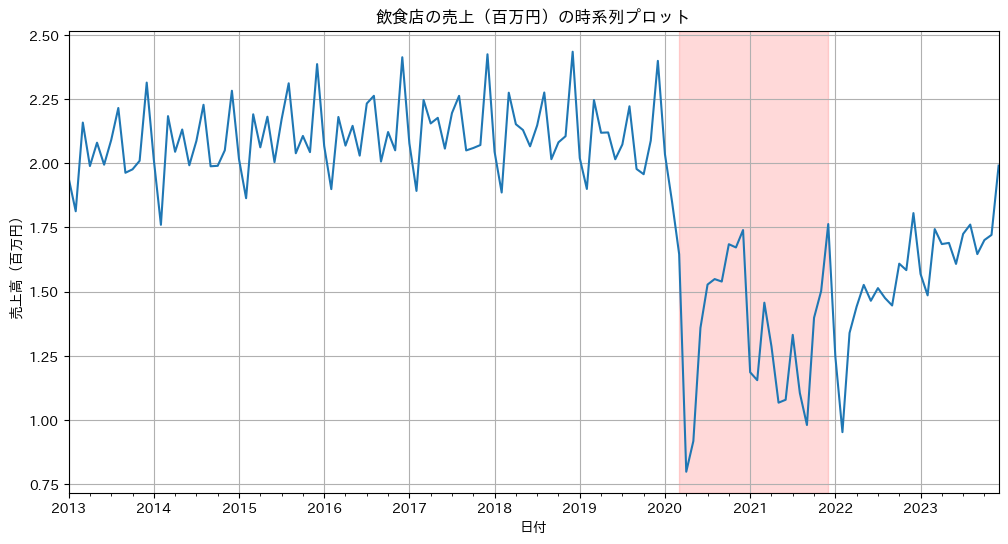

In [15]:
# ts_data の時系列プロットを描画
plt.figure(figsize=(12, 6))
ts_eating.plot(title='飲食店の売上（百万円）の時系列プロット')
plt.ylabel("売上高（百万円）")
plt.xlabel("日付")
plt.grid(True)

plt.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-01"),
            color="red", alpha=0.15, label="COVID period")

# plt.tight_layout()
plt.show()

## 3. 季節性プロット

ここで、時系列データの中に、「季節性」や「周期性」がないかを視覚的に確認するグラフを作成します。

- データを月ごと（1月〜12月）にグループ分け
- 月ごとに、過去の全データ（全年度分）を重ねてプロット
- 各月の平均値を水平線で表示


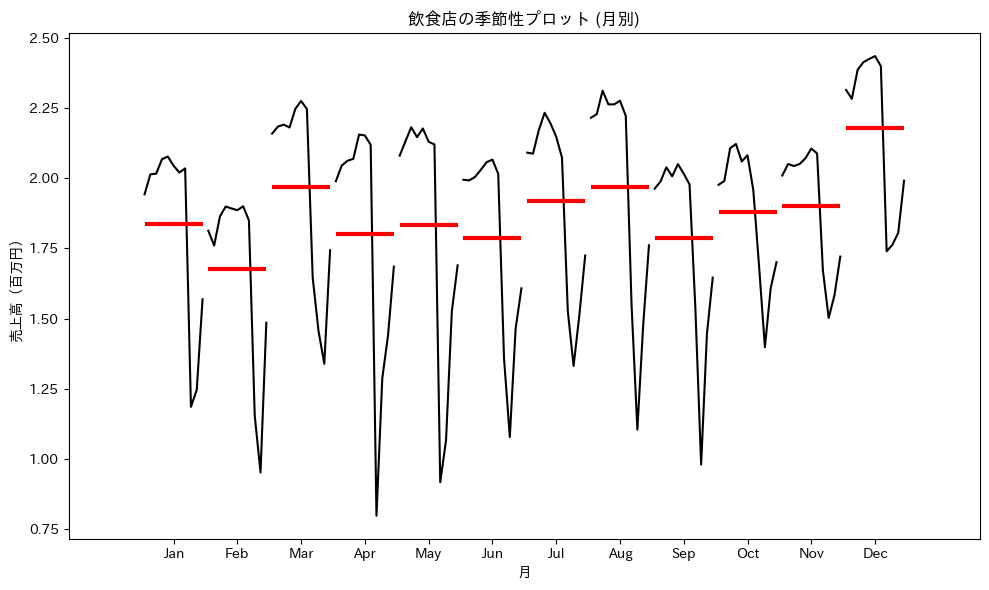

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.month_plot(ts_eating, ax=ax)
ax.set_title('飲食店の季節性プロット (月別)')
ax.set_ylabel("売上高（百万円）")
ax.set_xlabel("月")
plt.tight_layout()

このグラフから分かることを、確認していきます。

まず、特定の月に、高い（または低い）傾向があるかどうかです。

飲食店の売り上げのデータの場合、毎年3月、8月、12月（年度末、夏休み、年末年始）は売上が高い傾向があるようです。

各月のプロットが似たような形をしていれば、季節パターンが安定していると言えます。

あるいは、他の年と比べて、ある年の特定の月だけが大きく外れた値になっている場合、異常値が見出せます。
景気変動、イベント、コロナ禍などの、特殊な出来事が考えられます。

そして、季節性プロットで明確な山谷のパターンが確認できれば、12ヶ月周期の季節性があると判断でき、ARIMAモデルを構築する際に季節性を考慮する根拠となります。


## 4. 時系列の成分分解 (STL)


時系列の成分分解は、時系列データを、3つの成分に分解します。

1. **T** (Trend: トレンド成分)
  - データの長期的な傾向や、ゆっくりとした変動を表します。
    - 例えば、売上が長期的に上昇傾向にあるか、下降傾向にあるかなどを示します。

2. **S** (Seasonal: 季節成分)
  - 特定の周期（今回は12ヶ月）で繰り返されるパターンを表します。
    - 飲食店の売り上げであれば、夏休みや年末年始に売上が上がる、といった周期的な変動がこれにあたります。

3. **R** (Residual: 残差成分)
  - トレンド成分と季節成分を取り除いた後に残る、不規則な変動（ノイズ）や誤差を表します。


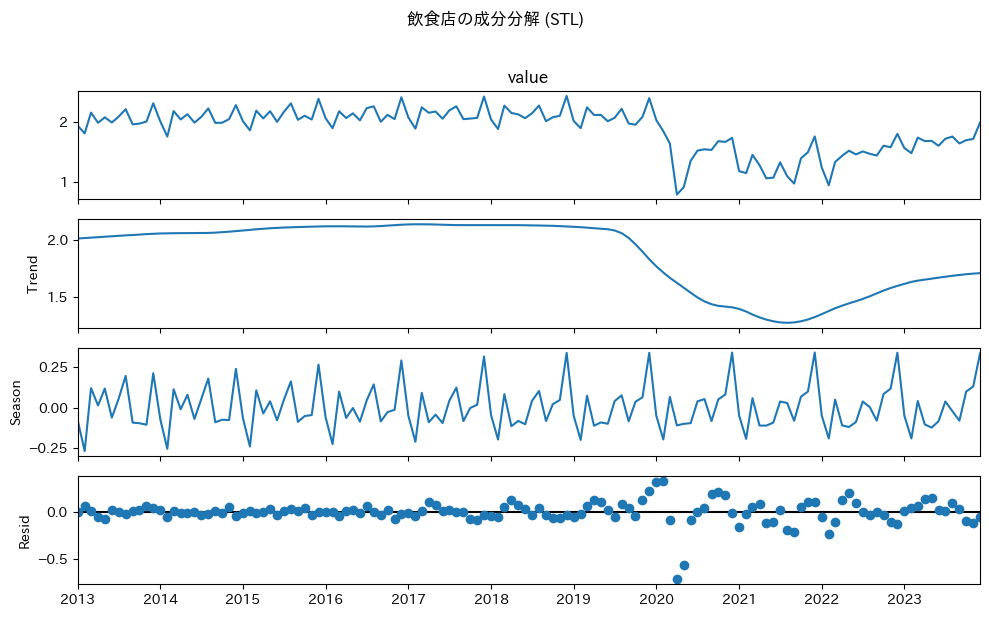

In [17]:
stl_eating = STL(ts_eating, period=12, seasonal=13)
decomp_eating = stl_eating.fit()

# 分解結果のプロット
fig = decomp_eating.plot()
fig.set_size_inches(10, 6)
fig.suptitle('飲食店の成分分解 (STL)', y=1.02)
plt.tight_layout()




- STL分解により、データの構造を可視化し、また、モデル選択の裏付けを行います。

  - STL は "Seasonal and Trend decomposition using Loess" の略で、 Loess（ロエス） という平滑化技術（滑らかにする）を使って、これらの成分を抽出します。

  - STL分解により、季節性プロットよりも詳細に、「12ヶ月周期の季節性がどれくらい強いか」「全体のトレンドは上昇しているか」「異常なノイズ（残差）はいつ発生しているか」を視覚的に確認できます。

  - STL で明確な季節成分が確認できれば、この後に分析する `auto_arima` で季節性を考慮する設定が妥当かどうかの参考になります。


## 5. ARIMAモデルによる予測

- `auto_arima()` で最適なARIMAモデルを自動選択します。

  - `auto_arima` は、実行をすると、かなり時間がかかります。

- `m=12` # 季節周期
- `D=1`  # 季節階差
- `seasonal=True` # 季節性を考慮
- `m=12` # 季節周期 (月次)


In [18]:
import warnings # arima で FutureWarning の警告が多く表示されるので、一時的に消す
warnings.simplefilter('ignore')

fit_arima_eating = pm.auto_arima(
    ts_eating,
    D=1,              # 季節階差
    seasonal=True,    # 季節性を考慮
    m=12,             # 季節周期 (月次)
    stepwise=False,   # フルサーチ
    suppress_warnings=True, # 警告を非表示
    trace=True        # 試行したモデルを表示
)

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=42.114, Time=0.29 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=44.000, Time=1.65 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=5.65 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=44.065, Time=0.33 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=34.363, Time=0.75 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=5.47 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-75.030, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-73.631, Time=0.60 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=3.11 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-73.313, Time=0.53 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.96 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-79

## モデルのサマリーを表示

- モデルのサマリーを表示します。


In [19]:
print(fit_arima_eating.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 12)   Log Likelihood                  82.864
Date:                              Sun, 02 Nov 2025   AIC                           -151.728
Time:                                      03:00:56   BIC                           -132.216
Sample:                                  01-01-2013   HQIC                          -143.804
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0021      0.005     -0.460      0.646      -0.011       0.007
ar.L1          0.95

分析の結果を見ていきます。

1. 決定されたモデル： `Model: SARIMAX(1, 0, 3)x(0, 1, [1], 12)`

  - `auto_arima` が最適と判断したモデルの構造です。
  - 「季節性」と「短期的な傾向」を組み合わせたモデルです。
  - `x(0, 1, [1], 12) (季節性の部分)`
    - `12:` データの周期が12ヶ月であることを示します。
    - `D=1` (真ん中の `1` ): 指定した `D=1` が採用されたことを表し、「今年の売上は、去年の同じ月の売上と関連がある」という前提で計算（1年前との差分）しています。
    - `ma.S.L12` `(Q=1)` : 12ヶ月前（1年前）の予測の「ズレ」（誤差） も、今月の予測に影響を与えていることを示します。非常に強力な予測要因です（ `P>|z|` が `0.000` のため）。

  - `(1, 0, 3)` (非季節性・短期的な部分)
    - `ar.L1` `(p=1)` : 1ヶ月前の売上が、今月の売上に影響を与えていることを示します。
    - `ma.L1` , `ma.L2` , `ma.L3` `(q=3)` : 1ヶ月前、2ヶ月前、3ヶ月前の予測の「ズレ」（誤差）も、今月の予測を修正するために使われていることを示します。

  - このモデルは、「12ヶ月周期の季節パターン」をベースにしつつ、「直近1〜3ヶ月の短期的な変動」も考慮して将来を予測する妥当なモデルです。


2. モデルの精度はどうか？ (係数と統計量)
  - モデルがデータにどれだけうまく当てはまっているかを見ます。

  - 係数のP値 `(P>|z|)`

    - `intercept` （切片）以外、 `ar.L1`  や `ma.L1` 〜 `ma.L3` 、そして `ma.S.L12` （季節性）のP値がすべて 0.05 より小さい（ほぼ 0.000）です。

    - モデルに採用された上記の要因（「1ヶ月前の売上」や「12ヶ月前の誤差」など）は、すべて統計的に意味があり、予測に役立っています。

  - モデル全体の診断 (下の表)

    - `Ljung-Box (L1) (Q): 0.01 / Prob(Q): 0.94`
    - これは「残差（予測の残りカス）に、もう予測できるようなパターンは残っていないか？」をチェックするテストです。
    - p値が 0.94 と非常に大きく、モデルが、データのパターン（季節性や傾向）をうまく「食べ尽くし」、残ったのはランダムなノイズだけであることを意味します。

  - `Jarque-Bera (JB): 376.24 / Prob(JB): 0.00`
    - これは「残差は正規分布（きれいな釣鐘型）か？」をチェックするテストです。
    - p値が 0.00 と非常に低く、残差は、正規分布に従っていないことを示します。




3. なぜ「悪い結果」が出たのか？ (JBテストと歪度/尖度)
    - `Prob(JB): 0.00` となった原因は、その下にある `Skew` （歪度）と  `Kurtosis` （尖度）にあります。

    - `Skew` (歪度): -2.03 （理想は 0）
      - マイナスに大きく偏っています。これは、予測よりも「下に大きく外れた（ネガティブな）外れ値」がいくつか存在することを示します。

    - `Kurtosis` (尖度): 10.66 （理想は3）
      - 10.66 と非常に高い値です。これは、分布が非常に「尖っている」こと、つまり「ほとんどの予測はうまく当たっているが、ごく稀に非常に大きな外れ値がある」ことを示します。



4. 総合的な解釈： Prob(Q) が高く、モデルは、「平時」の季節変動や短期トレンドは非常にうまく予測できています。

  - ただ、2013年〜2023年には、コロナ禍（2020年〜）のような、過去のパターンから予測できない異常な売上の落ち込みがあります。

  - モデルは「異常な落ち込み」を予測できなかったため、そこだけが「非常に大きなマイナスの残差（外れ値）」として残り、 Prob(JB) テストが悪い結果（正規分布ではない）となっています。




5. 結論

  - コロナ禍のような外れ値を除けば、データの季節性や傾向をうまく捉えている、信頼性の高いモデルと解釈できます。

  - `Heteroskedasticity (H)` の `Prob(H): 0.00` が、平常時と有事とで、予測誤差の大きさが異なるということを表しています。
    - ヘテロセダスティシティ (分散の不均一性) とは、回帰分析において、誤差項の分散が一定ではない状態を意味します。
    - p値（0.00）が小さく、誤差項の分散が均一であるという帰無仮説を棄却 = 予測誤差の大きさが、過去から現在まで均一とは言えない（大きさが違う）


## 6. 残差チェック

残差の診断です。 コロナ禍の 2020年ごろの残差がとても大きいです。


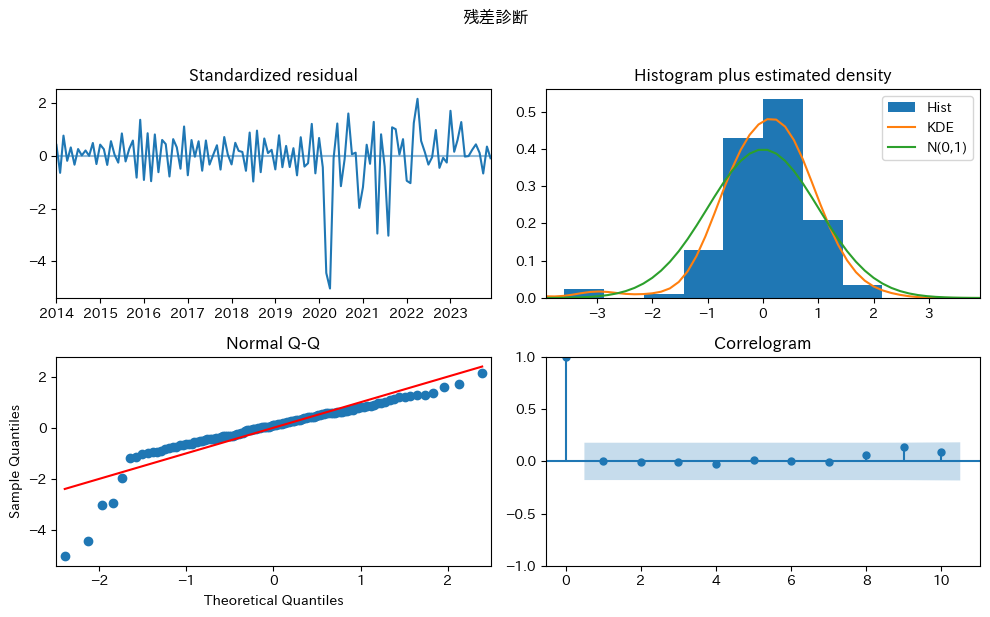

In [20]:
fig = fit_arima_eating.plot_diagnostics(figsize=(10, 6))
fig.suptitle('残差診断', y=1.02)
plt.tight_layout()



## 7. 予測と可視化

- ここでは、24ヶ月先まで予測を行ってみます。
  - `n_periods = 24`


In [21]:
n_periods = 24
preds_eating, conf_int_eating = fit_arima_eating.predict(
    n_periods=n_periods,
    return_conf_int=True,
    alpha=0.05  # 95%信頼区間
)


## 予測結果のインデックス（日付）を作成

- 予測結果のインデックス（日付）を作成します。


In [22]:
index_of_fc_eating = pd.date_range(
    ts_eating.index[-1] + pd.offsets.MonthBegin(1),
    periods=n_periods,
    freq='MS'
)


## 予測結果と信頼区間を Pandas Series に変換

- 予測結果と信頼区間を Pandas Series に変換します。


In [23]:
fc_series_eating = pd.Series(preds_eating, index=index_of_fc_eating)
lower_series_eating = pd.Series(conf_int_eating[:, 0], index=index_of_fc_eating)
upper_series_eating = pd.Series(conf_int_eating[:, 1], index=index_of_fc_eating)

## プロット

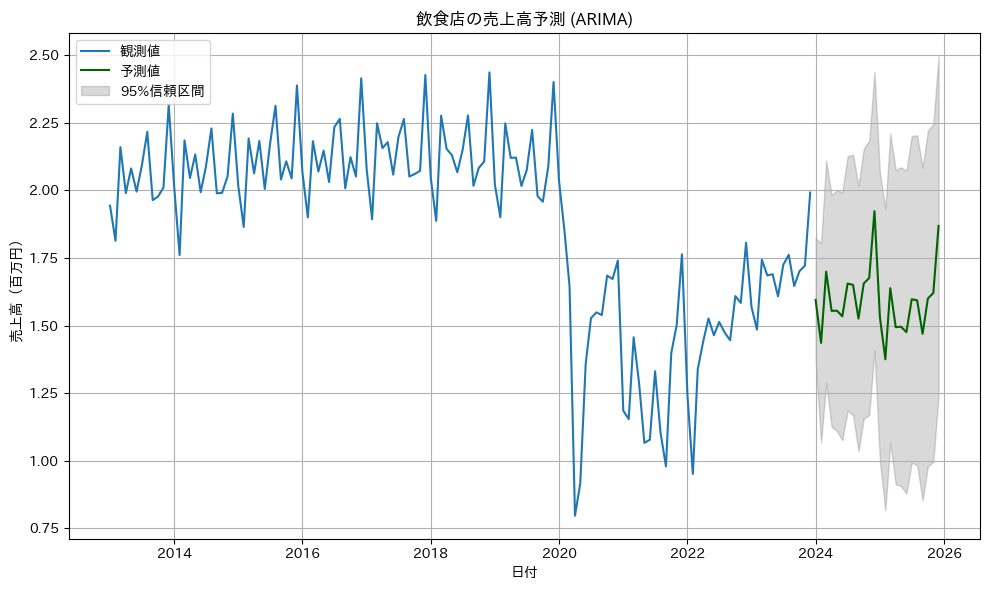

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(ts_eating, label='観測値')
plt.plot(fc_series_eating, label='予測値', color='darkgreen')
plt.fill_between(
    lower_series_eating.index,
    lower_series_eating,
    upper_series_eating,
    color='k',
    alpha=0.15,
    label='95%信頼区間'
)
plt.title(f'飲食店の売上高予測 (ARIMA)')
plt.ylabel("売上高（百万円）")
plt.xlabel("日付")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

- 予測の幅が広くなってしまっていることが見てとれます。


# 4. インターネット附随サービス業の売上

先ほどの、産業の種類を表す `industry` 列に入っている内容を確認すると、  `"40Internet based services"` という値が存在します。

このデータを使って、インターネット附随サービス業の売上を時系列順にプロットしてみます。まずは、インターネット附随サービス業のデータだけを取り出します。

In [25]:
df_internet = df_monthly.dropna(subset=["date"])[df["industry"] == "40Internet based services"].copy()
df_internet


,@tab,@cat01,@area,@time,@unit,$,industry,area,time_name,value,date
1177,001,02040,00000,2013000101,1 mil.yen,217374,40Internet based services,Japan,Jan. 2013,217374,2013-01-01
1178,001,02040,00000,2013000202,1 mil.yen,221461,40Internet based services,Japan,Feb. 2013,221461,2013-02-01
1179,001,02040,00000,2013000303,1 mil.yen,239275,40Internet based services,Japan,Mar. 2013,239275,2013-03-01
1180,001,02040,00000,2013000404,1 mil.yen,216303,40Internet based services,Japan,Apr. 2013,216303,2013-04-01
1181,001,02040,00000,2013000505,1 mil.yen,224831,40Internet based services,Japan,May 2013,224831,2013-05-01
...,...,...,...,...,...,...,...,...,...,...,...
1304,001,02040,00000,2023000808,1 mil.yen,393031,40Internet based services,Japan,Aug. 2023,393031,2023-08-01
1305,001,02040,00000,2023000909,1 mil.yen,421912,40Internet based services,Japan,Sep. 2023,421912,2023-09-01
1306,001,02040,00000,2023901010,1 mil.yen,383381,40Internet based services,Japan,Oct. 2023 p,383381,2023-10-01
1307,001,02040,00000,2023901111,1 mil.yen,396588,40Internet based services,Japan,Nov. 2023 p,396588,2023-11-01


In [26]:
df_internet = df_monthly.dropna(subset=["date"])[df["industry"] == "40Internet based services"].copy()
#print(df_internet.shape)
#print(df_internet["date"].dtype)

start = "2018-01-01"
end   = "2018-08-01"
df_range_internet = df_internet[(df_internet["date"] >= start) & (df_internet["date"] <= end)]
df_range_internet

,@tab,@cat01,@area,@time,@unit,$,industry,area,time_name,value,date
1237,001,02040,00000,2018000101,1 mil.yen,275894,40Internet based services,Japan,Jan. 2018,275894,2018-01-01
1238,001,02040,00000,2018000202,1 mil.yen,269467,40Internet based services,Japan,Feb. 2018,269467,2018-02-01
1239,001,02040,00000,2018000303,1 mil.yen,314768,40Internet based services,Japan,Mar. 2018,314768,2018-03-01
1240,001,02040,00000,2018000404,1 mil.yen,277921,40Internet based services,Japan,Apr. 2018,277921,2018-04-01
1241,001,02040,00000,2018000505,1 mil.yen,279758,40Internet based services,Japan,May 2018,279758,2018-05-01
1242,001,02040,00000,2018000606,1 mil.yen,291780,40Internet based services,Japan,Jun. 2018,291780,2018-06-01
1243,001,02040,00000,2018000707,1 mil.yen,296311,40Internet based services,Japan,Jul. 2018,296311,2018-07-01
1244,001,02040,00000,2018000808,1 mil.yen,291228,40Internet based services,Japan,Aug. 2018,291228,2018-08-01


取り出せたので、インターネット附随サービス業の売上データをプロットしてみます。


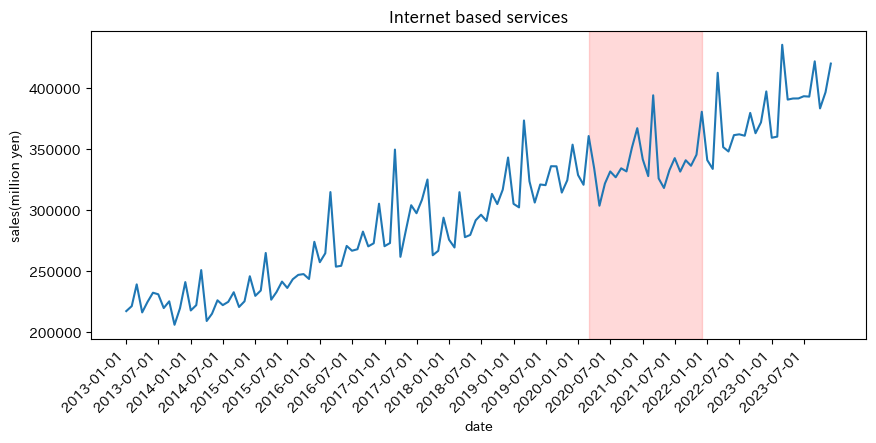

In [27]:
plt.figure(figsize=(10,4))
plt.plot(df_internet.date, df_internet.value, label="money")
plt.xlabel("date")
plt.ylabel("sales(million yen)")
plt.title("Internet based services")
step = 6
xticks = df_internet["date"].iloc[::step]   # 5行おきに抜き出す

plt.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-01"),
            color="red", alpha=0.15, label="COVID period")

plt.xticks(xticks, rotation=45, ha="right")
plt.show()

## 時系列データ `ts_internet` を作成

- 先ほどと同じようなことを繰り返します。
- 関数にして汎用化をすると良さそうですが、練習の意味も込めて、もう一度作成してみます。


In [28]:
# df_internet を元にして ts_internet を作成
ts_internet = df_internet.set_index('date')['value']

# インデックスの頻度を 'MS' (月の初日) に設定 (すでに datetime型なのでfreqを設定するのみ)
ts_internet.index.freq = 'MS'

# 百万円の単位を合わせるため、100万で割る
ts_internet = ts_internet / 1_000_000

print("対象列: 'インターネット附随サービス業の売上（百万円）'")
print("データ（先頭5行）:\n", ts_internet.head())

対象列: 'インターネット附随サービス業の売上（百万円）'
データ（先頭5行）:
 date
2013-01-01    0.217374
2013-02-01    0.221461
2013-03-01    0.239275
2013-04-01    0.216303
2013-05-01    0.224831
Freq: MS, Name: value, dtype: float64


## 2. 時系列の可視化 (生データ)

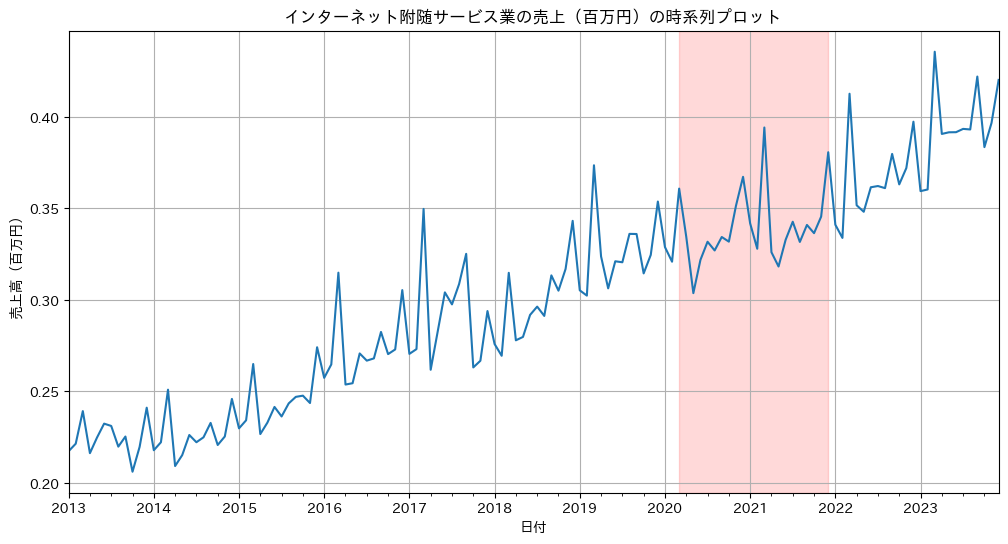

In [29]:
# ts_internet の時系列プロットを描画
plt.figure(figsize=(12, 6))
ts_internet.plot(title='インターネット附随サービス業の売上（百万円）の時系列プロット')
plt.ylabel("売上高（百万円）")
plt.xlabel("日付")
plt.grid(True)

plt.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-01"),
            color="red", alpha=0.15, label="COVID period")

# plt.tight_layout()
plt.show()

先ほどの、飲食店の売り上げのデータと異なり、トレンドが分かりやすく、コロナ禍の落ち込みも、意外なくらいに見当たりません。

コロナ禍における経済的ダメージという観点で見ると、産業によって、これほど大きな違いがあることに驚きます。


## 3. 季節性プロット

- statsmodels の month_plot (Rのggseasonplotに相当)

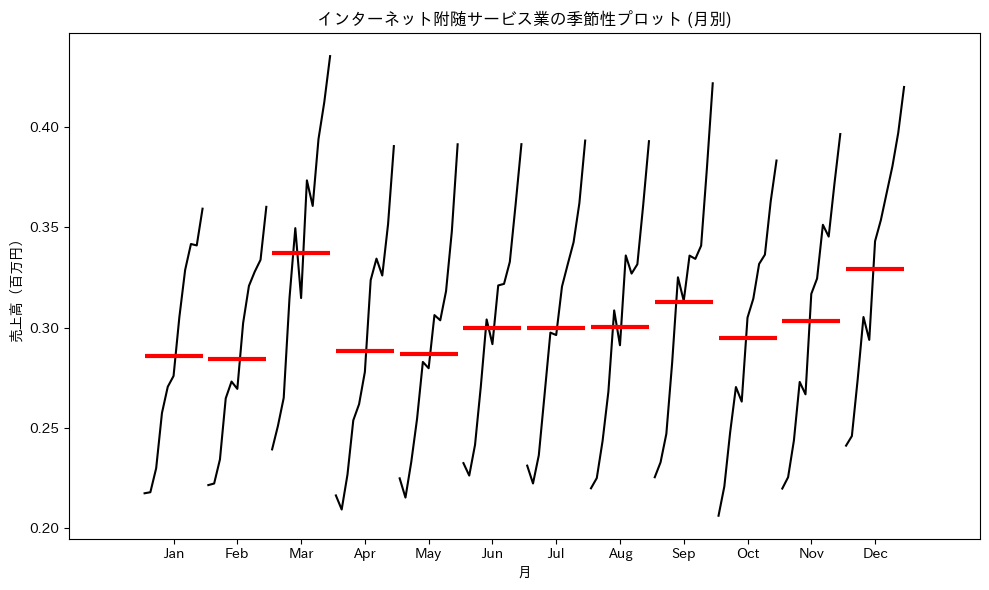

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.month_plot(ts_internet, ax=ax)
ax.set_title('インターネット附随サービス業の季節性プロット (月別)')
ax.set_ylabel("売上高（百万円）")
ax.set_xlabel("月")
plt.tight_layout()

3月ごろ、12月ごろに売り上げが伸びていることは、先ほどの飲食店の売り上げデータと同様と言えます。


## 4. 時系列の成分分解 (STL)

- 上昇していくトレンドが明白です。

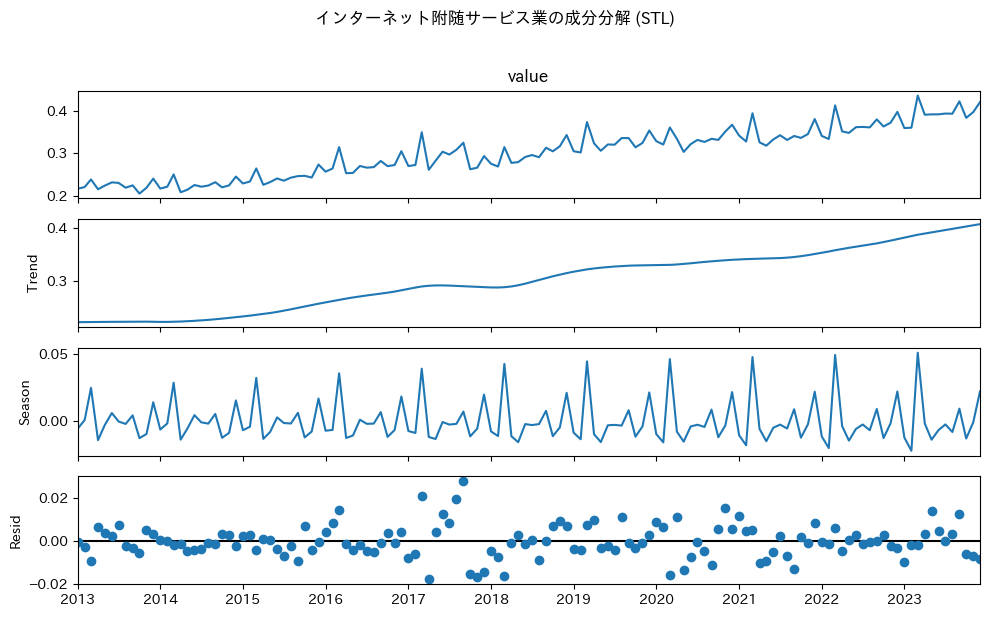

In [31]:
stl_internet = STL(ts_internet, period=12, seasonal=13)
decomp_internet = stl_internet.fit()

# 分解結果のプロット
fig_internet = decomp_internet.plot()
fig_internet.set_size_inches(10, 6)
fig_internet.suptitle('インターネット附随サービス業の成分分解 (STL)', y=1.02)
plt.tight_layout()


## 5. ARIMAモデルによる予測

- `auto_arima()` で最適なARIMAモデルを自動選択
  - `auto_arima` は、実行をすると、時間がかかります。

- `m=12` # (季節周期)
- `D=1`  # 季節階差
- `seasonal=True` # 季節性を考慮
- `stepwise=False` # フルサーチ


In [32]:
fit_arima_internet = pm.auto_arima(
    ts_internet,
    D=1,              # 季節階差
    seasonal=True,    # 季節性を考慮
    m=12,             # 季節周期 (月次)
    stepwise=False,   # フルサーチ
    suppress_warnings=True, # 警告を非表示
    trace=True        # 試行したモデルを表示
)

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-636.807, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-678.829, Time=0.86 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=-676.879, Time=3.47 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-652.787, Time=1.13 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-663.456, Time=2.04 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-676.964, Time=2.88 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=-646.272, Time=5.37 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-671.028, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-706.231, Time=0.88 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-705.339, Time=3.21 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-686.500, Time=0.91 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-704.824, Time=1.65 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-703.208, Time=5.02 sec
 ARIM

## インターネット附随サービス業の売り上げのモデルのサマリーを表示

- モデルのサマリーを表示します。


In [33]:
print(fit_arima_internet.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 367.095
Date:                              Sun, 02 Nov 2025   AIC                           -722.189
Time:                                      03:04:44   BIC                           -705.464
Sample:                                  01-01-2013   HQIC                          -715.397
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0045      0.002      2.491      0.013       0.001       0.008
ar.L1          0.45

インターネット附随サービス業の売り上げは、飲食店の売り上げの分析と比べて、非常に安定していて、完璧に近いほど、優等生的なモデルということになります。

- 飲食店の売り上げは、コロナ禍という外れ値の影響で、予測が難しい部分がありました。
- インターネット附随サービス業の売上は、驚くほど安定して予測可能となっています。



1. 決定されたモデル
  - `Model: SARIMAX(3, 0, 0)x(0, 1, [1], 12)`
  - `auto_arima` が見つけた「インターネット附随サービス業」の売上パターン
  - `x(0, 1, [1], 12)` が、季節性の部分
  - 飲食店の売り上げと、同じ構造です。
  - `D=1`
    - 「1年前の今月」の売上と比較

  - `ma.S.L12 (Q=1)`
    - 「12ヶ月前（1年前）の予測のズレ」を考慮して、今月の予測を修正

  - 強力な12ヶ月周期の季節性が、このデータに見られます。

  - `(3, 0, 0)`
    - 非季節性・短期的な部分

  - `p=3`
    - 「1ヶ月前、2ヶ月前、3ヶ月前の売上」が、今月の売上に影響
    - ただし、 `P>|z|` を見ると、 `ar.L1`（1ヶ月前）の影響が圧倒的に強い
    - 2・3ヶ月前の影響は限定的

  - `q=0`
    - 「宿泊飲食」とは異なり、「過去の予測のズレ（誤差）」を考慮しなくても、過去の売上だけで短期的な予測がうまくいく

- 飲食店の売り上げのモデルは、「12ヶ月周期の季節パターン」をベースにしつつ、「直近1〜3ヶ月の売上実績」を使って将来を予測するモデル



2. モデルの精度はどうか？ (診断結果)

  - 飲食店の売り上げモデルと大きく異なり、ほぼ満点に近い素晴らしい精度

  - `Ljung-Box (L1) (Q): 0.05 / Prob(Q): 0.83`
    - p値（0.83）が非常に高い

  - モデルがデータのパターン（季節性や傾向）を完璧に捉えきっており、予測の「残りカス」は完全にランダムなノイズであることを示している

  - `Jarque-Bera (JB): 4.82 / Prob(JB): 0.09`
    - p値（0.09）が 0.05 よりも高い

  - 「残差は正規分布に従っている」という理想的な状態をクリアしている

  - `Skew` (歪度): 0.13 （理想は0）

  - 歪度はほぼ0で、飲食店売り上げのように、下に（マイナスに）大きく外れるようなショックがなかった

  - `Heteroskedasticity (H): 0.89 / Prob(H): 0.71`
    - ヘテロセダスティシティ (分散の不均一性) は、回帰分析において、誤差項の分散が一定ではない状態を意味します。
    - p値（0.71）が大きく、誤差項の分散が均一であるという帰無仮説を棄却出来ない = 予測誤差の大きさが、過去から現在まで均一
    - コロナ禍のような特定の期間だけ予測が難しくなる（荒れる）ということがなく、非常に安定したデータ


結論：「宿泊飲食」との決定的な違い

- 飲食店売り上げのモデルは、コロナ禍という甚大な事態（外れ値）によって、残差の正規分布が崩れていた
  - `Prob(JB): 0.00, Skew: -2.03`

- しかし、インターネット附随サービス業の売り上げのモデルは、すべての診断テストをクリアしている

- インターネット附随サービス業の売上が、パンデミックのような社会的な混乱期においても、過去の季節パターンや短期トレンドから逸脱することなく、非常に安定的に推移していたことを示している

- `SARIMAX(3, 0, 0)x(0, 1, [1], 12)` モデルは、極めて信頼性が高く、精度の良い予測モデルであると解釈できる。


## 6. 残差チェック

残差の診断を可視化します。

飲食店の売り上げデータと比較すると、インターネット附随サービス業の売り上げでは、コロナ禍の大きな落ち込みという外れ値は、どちらかというと見られません。


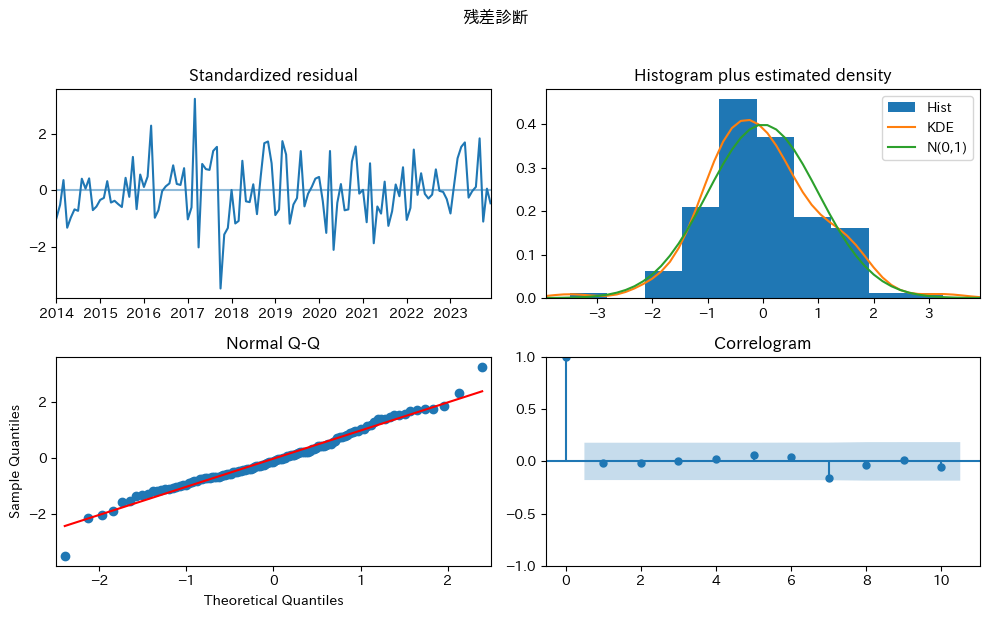

In [34]:
fig = fit_arima_internet.plot_diagnostics(figsize=(10, 6))
fig.suptitle('残差診断', y=1.02)
plt.tight_layout()



## 7. 予測と可視化

- ここでは、インターネット附随サービス業の売り上げについて、24ヶ月先まで予測を行ってみます。
  - `n_periods = 24`


In [35]:
n_periods = 24
preds_internet, conf_int_internet = fit_arima_internet.predict(
    n_periods=n_periods,
    return_conf_int=True,
    alpha=0.05  # 95%信頼区間
)


## 予測結果のインデックス（日付）を作成

- 予測結果のインデックス（日付）を作成します。


In [36]:
index_of_fc_internet = pd.date_range(
    ts_internet.index[-1] + pd.offsets.MonthBegin(1),
    periods=n_periods,
    freq='MS'
)


## 予測結果と信頼区間を Pandas Series に変換

- 予測結果と信頼区間を Pandas Series に変換します。


In [37]:
fc_series_internet = pd.Series(preds_internet, index=index_of_fc_internet)
lower_series_internet = pd.Series(conf_int_internet[:, 0], index=index_of_fc_internet)
upper_series_internet = pd.Series(conf_int_internet[:, 1], index=index_of_fc_internet)

## プロット

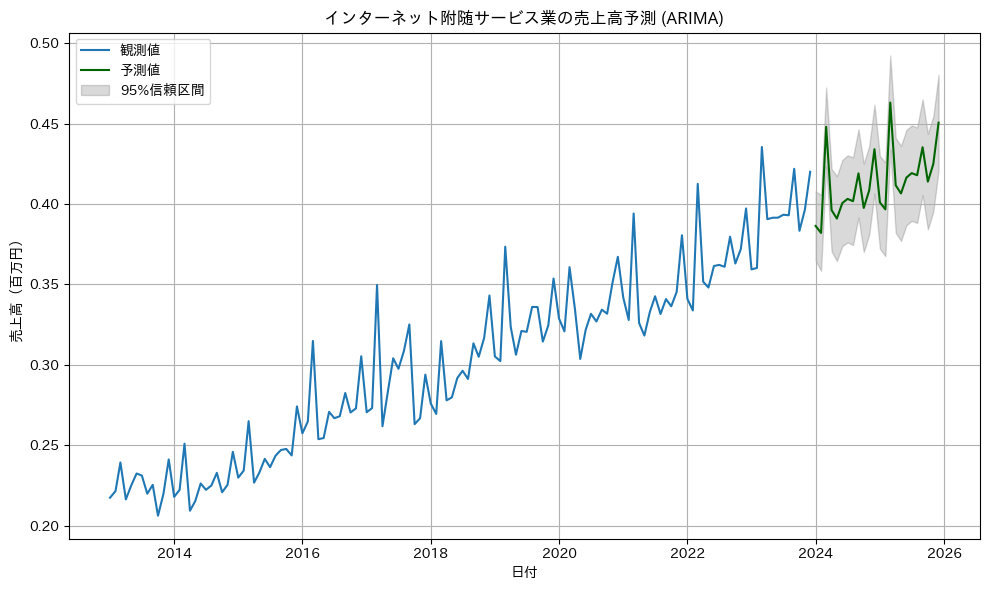

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(ts_internet, label='観測値')
plt.plot(fc_series_internet, label='予測値', color='darkgreen')
plt.fill_between(
    lower_series_internet.index,
    lower_series_internet,
    upper_series_internet,
    color='k',
    alpha=0.15,
    label='95%信頼区間'
)
plt.title('インターネット附随サービス業の売上高予測 (ARIMA)')
plt.ylabel("売上高（百万円）")
plt.xlabel("日付")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

飲食店の売り上げに対する予測に比べ、インターネット附随サービス業の売り上げに対する予測の方が、小さい狭い幅で、より正確に予測ができている様子が伺えます。


# 5. 暫定的なまとめ


- 現時点では、飲食店とインターネット附随サービス業という二つの時系列データの比較にとどまっています。

- ただ、これらのデータは、コロナ禍による経済的影響という観点から、とても対照的なデータとなっていました。
産業によって被る影響の違いがよく分かるコントラストを描いていました。

- 今後、他の産業についても比較検討し、日本の産業構造のあり方に寄与できるような知見を得たいです。
